In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


import torch.nn.functional as F
from pathlib import Path
import pprint

import json
import random

from tqdm import tqdm

### Load configurations

In [ ]:
import sys
!{sys.executable} -m pip install pyyaml

import json
import yaml
import os

print("Modules imported successfully, and pyyaml installed if not already present.")

Modules imported successfully, and pyyaml installed if not already present.


In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training'
all_configs = {}

for item in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, item)

    if os.path.isdir(subdir_path):
        config_found = False

        subfolder_name =  os.path.basename(subdir_path)
        # Prioritize config.json
        json_path = os.path.join(subdir_path, 'model_cfg.json')
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f:
                    config = json.load(f)
                    all_configs[subfolder_name] = config
                    print(f"Loaded config.json from {item}")
                config_found = True
            except Exception as e:
                print(f"Error loading config.json from {item}: {e}")

print(f"Total configurations loaded: {len(all_configs)}")
# Display the complete list of configurations (for verification)
# for i, config in enumerate(all_configs):
#     print(f"\nConfiguration {i+1}:\n{json.dumps(config, indent=2)}")

Loaded config.json from exp3_gpt2_8
Loaded config.json from exp4_gpt2_8
Loaded config.json from exp2_gpt2_8
Loaded config.json from exp5_gpt2_16
Loaded config.json from exp6_gpt2_16
Loaded config.json from exp7_gpt2_32
Loaded config.json from exp8_gpt2_128
Loaded config.json from exp9_gpt2_32
Loaded config.json from exp10_gpt2_8
Total configurations loaded: 9


In [ ]:
req_exps = ['exp10_gpt2_8', 'exp5_gpt2_16', 'exp7_gpt2_32', 'exp8_gpt2_128']

sel_configs = {}
for exp in req_exps:
  sel_configs[exp] = all_configs[exp]

### Model Definition

In [ ]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(cfg["device"])

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

    def get_version(self):
        version_list = [int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)]
        if len(version_list):
            return 1+max(version_list)
        else:
            return 0

    def save(self):
        version = self.get_version()
        torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
        with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
            json.dump(cfg, f)
        print("Saved as version", version)

    @classmethod
    def load(cls, version):
        cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
        return self

### Data Definition and Loading - Test data creation

In [ ]:
# Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader

In [ ]:
class ResidualDataset(Dataset):
    def __init__(self, data):
        self.residuals = data["residuals_post_attn"]
        self.tokens = data["tokens"]
        self.sentence_idx = data["sentence_idx"]
        self.position_idx = data["position_idx"]

    def __len__(self):
        return self.residuals.shape[0]

    def __getitem__(self, idx):
        return {
            "activations": self.residuals[idx],
            "token": self.tokens[idx],
            "sentence_idx": self.sentence_idx[idx],
            "position_idx": self.position_idx[idx],
        }

In [ ]:
res_act_file = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/financial_phrasebank_gpt2_layer9_residuals.pt"

In [ ]:
data = torch.load(res_act_file)

In [ ]:
dataset = ResidualDataset(data)

In [ ]:
total = len(dataset)
train_size = int(0.85 * total)
val_size   = int(0.05 * total)
test_size  = total - train_size - val_size


In [ ]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible
)

In [ ]:
# torch.save(train_dataset, "/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_train.pt")
# torch.save(val_dataset,   "/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_val.pt")
# torch.save(test_dataset,  "/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_test.pt")

### Load Test Data

In [ ]:
# Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split, DataLoader

In [ ]:
class ResidualDataset(Dataset):
    def __init__(self, data):
        self.residuals = data["residuals_post_attn"]
        self.tokens = data["tokens"]
        self.sentence_idx = data["sentence_idx"]
        self.position_idx = data["position_idx"]

    def __len__(self):
        return self.residuals.shape[0]

    def __getitem__(self, idx):
        return {
            "activations": self.residuals[idx],
            "token": self.tokens[idx],
            "sentence_idx": self.sentence_idx[idx],
            "position_idx": self.position_idx[idx],
        }

In [ ]:
test_dataset = torch.load("/content/drive/MyDrive/Colab Notebooks/SLDS_Project/token_activations/phrase_gpt2_l9_test.pt", weights_only=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Model Loading and Run

In [ ]:
sel_configs.keys()

dict_keys(['exp10_gpt2_8', 'exp5_gpt2_16', 'exp7_gpt2_32', 'exp8_gpt2_128'])

In [ ]:
model_key = 'exp10_gpt2_8'

#### Load and configure config

In [ ]:
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

In [ ]:
def load_config(cfg : dict):
    SEED = cfg["seed"]
    GENERATOR = torch.manual_seed(SEED)
    cfg["device"] = "cuda" if torch.cuda.is_available() else "cpu"

    return cfg

#### Load Model

In [ ]:
def load_model(cfg, weights_path):
    sae_model = SparseAutoEncoder(cfg)

    state_dict = torch.load(weights_path, map_location=torch.device(cfg["device"]))
    sae_model.load_state_dict(state_dict)
    sae_model.eval()

    return sae_model

#### Get activations

In [ ]:
# Getting activations and tokens
hidden_activations = []
all_tokens = []

In [ ]:
def get_test_activations(sae_model, test_loader):

    hidden_activations = []
    all_tokens = []

    for batch_idx, batch in enumerate(test_loader):
        activations = batch["activations"].to(cfg['device'])

        # Tokens
        tokens = batch["token"]
        all_tokens.extend(tokens)

        # Get hidden layer weights
        loss, x_reconstruct, mid_acts, l2_loss, l1_loss = sae_model(activations)

        # Store hidden activations
        hidden_activations.append(mid_acts)

    hidden_activations = torch.cat(hidden_activations, dim=0)

    return hidden_activations, all_tokens

#### Loop through each model and get activations

In [ ]:
all_model_activations = {}
all_tokens = None

In [ ]:
for model_key, cfg in sel_configs.items():

    print(f"Processing model: {model_key}")

    # get config
    cfg = load_config(cfg)

    # Get model with weights
    SAVE_DIR = f"/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training/{model_key}"
    weights_path = os.path.join(SAVE_DIR, "model_weight.pt")

    sae_model = load_model(cfg, weights_path)


    # Get activations and tokens
    hidden_activations, tokens = get_test_activations(sae_model, test_loader)

    # Merge
    all_model_activations[model_key] = hidden_activations

    if all_tokens is None:
        all_tokens = tokens  # Store tokens only once




Processing model: exp10_gpt2_8
Processing model: exp5_gpt2_16
Processing model: exp7_gpt2_32
Processing model: exp8_gpt2_128


### Autoencoder Training Results

In [114]:
import torch

path = "/content/drive/MyDrive/Colab Notebooks/SLDS_Project/autoencoder_training/exp7_gpt2_32/loss_list.pt"

loss_list = torch.load(path, map_location="cpu")
loss_list = loss_list[::200]
print(loss_list)

[{'loss': 751867.75, 'l2_loss': 751065.0625, 'l1_loss': 802.6581420898438}, {'loss': 1492.5087890625, 'l2_loss': 1133.0252685546875, 'l1_loss': 359.48358154296875}, {'loss': 1299.83837890625, 'l2_loss': 621.2308349609375, 'l1_loss': 678.6074829101562}, {'loss': 1968.853759765625, 'l2_loss': 1262.7060546875, 'l1_loss': 706.147705078125}, {'loss': 1158.79248046875, 'l2_loss': 258.8545837402344, 'l1_loss': 899.9378662109375}, {'loss': 316.8440246582031, 'l2_loss': 140.53407287597656, 'l1_loss': 176.30995178222656}, {'loss': 416.44866943359375, 'l2_loss': 174.84571838378906, 'l1_loss': 241.60293579101562}, {'loss': 670.39453125, 'l2_loss': 246.89736938476562, 'l1_loss': 423.4971618652344}, {'loss': 598.138427734375, 'l2_loss': 193.21072387695312, 'l1_loss': 404.927734375}, {'loss': 499.2820739746094, 'l2_loss': 118.81920623779297, 'l1_loss': 380.4628601074219}, {'loss': 695.3610229492188, 'l2_loss': 143.7206573486328, 'l1_loss': 551.640380859375}, {'loss': 360.8525390625, 'l2_loss': 118.17

In [115]:
len(loss_list)

69

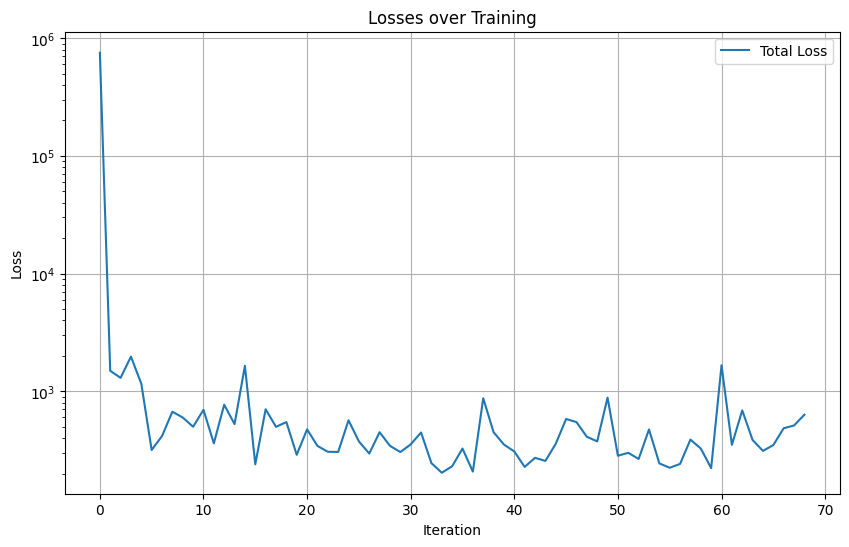

In [116]:
import matplotlib.pyplot as plt

# Extract losses
total_loss = [entry['loss'] for entry in loss_list]
l2_loss = [entry['l2_loss'] for entry in loss_list]
l1_loss = [entry['l1_loss'] for entry in loss_list]

# Plot
plt.figure(figsize=(10,6))
plt.plot(total_loss, label='Total Loss')
# plt.plot(l2_loss, label='L2 Loss')
# plt.plot(l1_loss, label='L1 Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Losses over Training')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Get feature scores

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_tokens = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SLDS_Project/test_financial_score.csv")

In [ ]:
df_tokens_score = df_tokens[["token_text","finbert_llr_financial"]]

# normalize min max
df_tokens_score["finbert_llr_financial"] = (df_tokens_score["finbert_llr_financial"] - df_tokens_score["finbert_llr_financial"].min())
df_tokens_score["finbert_llr_financial"] = df_tokens_score["finbert_llr_financial"] / (df_tokens_score["finbert_llr_financial"].max() - df_tokens_score["finbert_llr_financial"].min())


/tmp/ipython-input-457410884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens_score["finbert_llr_financial"] = (df_tokens_score["finbert_llr_financial"] - df_tokens_score["finbert_llr_financial"].min())
/tmp/ipython-input-457410884.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens_score["finbert_llr_financial"] = df_tokens_score["finbert_llr_financial"] / (df_tokens_score["finbert_llr_financial"].max() - df_tokens_score["finbert_llr_financial"].min())


In [ ]:
df_tokens_score.describe()

,finbert_llr_financial
count,13841.000000
mean,0.299109
std,0.262799
min,0.000000
25%,0.115225
50%,0.203050
75%,0.373341
max,1.000000


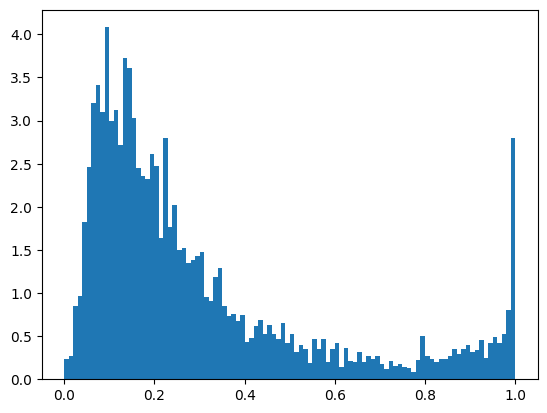

In [ ]:
plt.hist(df_tokens_score["finbert_llr_financial"],bins=100, density=True)
plt.show()

### Analysis

#### Feature Firing Frequencies

In [ ]:
gpt4_acts = all_model_activations['exp10_gpt2_8']

In [ ]:
import torch


def plot_feature_frequencies(all_model_activations, bins=100, figsize=(10,5)):
    """
    Plots SAE feature firing frequency distributions for multiple models.

    Args:
        all_model_activations (dict): model_name -> tensor of shape (N, d)
        bins (int): number of bins for histogram
        figsize (tuple): figure size
    """
    plt.figure(figsize=figsize)

    for model_name, acts in all_model_activations.items():
        # Convert to CPU if necessary
        acts = acts.cpu() if acts.is_cuda else acts

        # Compute binary firing: True if activation > 0
        fired = acts > 0  # shape (N, d)

        # Count times each feature fires
        fire_counts = fired.sum(dim=0)  # shape (d,)

        # Convert to frequency (fraction of tokens)
        frequencies = fire_counts / acts.size(0)
        frequencies_log = torch.log10(frequencies + 1e-8)

        # Histogram
        label_name = "Dict x" + model_name.split('_')[-1]
        plt.hist(frequencies_log.numpy(), bins=bins, alpha=0.5, label=label_name, density=True)

    plt.xlabel("Feature firing frequency (Log10)")
    plt.ylabel("Density")
    plt.title("SAE Feature Firing Frequency")
    plt.legend()
    plt.show()


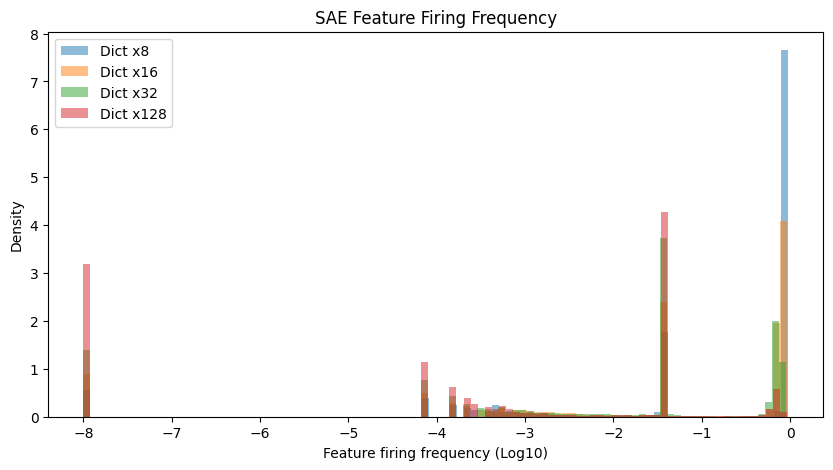

In [ ]:
plot_feature_frequencies(all_model_activations)

##### Average feature firing frequencies

### Feature identification from Finbert

In [ ]:
min_log_fire_rate = (-4.5, -2)

In [ ]:
def identify_financial_features(
    acts: torch.Tensor,
    token_fin_scores: torch.Tensor,
    top_k: int = 50,
    min_fires: int = 10
):
    """
    Identify SAE features aligned with financial tokens.

    Returns:
        selected_features: list of feature indices
        feature_alignment: tensor of alignment scores (size d)
    """
    acts = acts.cpu()
    token_fin_scores = token_fin_scores.cpu()

    N, d = acts.shape
    baseline = token_fin_scores.mean()

    alignment = torch.zeros(d)
    fire_counts = torch.zeros(d)
    # Convert to frequency (fraction of tokens)
    frequencies = torch.zeros(d)
    frequencies_log = torch.zeros(d)


    for f in range(d):
        fired = acts[:, f] > 0
        fire_counts[f] = fired.sum()

        # Convert to frequency (fraction of tokens)
        frequencies[f] = fire_counts[f] / acts.size(0)
        frequencies_log[f] = torch.log10(frequencies[f] + 1e-8)

    if (fire_counts[f] >= min_log_fire_rate[0]) & (frequencies_log[f] <= min_log_fire_rate[1]) :
        alignment[f] = token_fin_scores[fired].mean() - baseline
    else:
        alignment[f] = float("-inf")  # ignore rarely firing features

    # Select top-K financial features
    selected_features = torch.topk(alignment, top_k).indices.tolist()

    return selected_features, alignment


In [ ]:
financial_scores = torch.tensor(df_tokens_score["finbert_llr_financial"].values)

In [ ]:
alignment_scores_by_model = {}

for model_key, acts in all_model_activations.items():
    _, alignment_scores = identify_financial_features(
        acts=acts,
        token_fin_scores=financial_scores,
        top_k=acts.shape[1],   # effectively no cutoff
        min_fires=10
    )

    alignment_scores_by_model[model_key] = alignment_scores

In [ ]:
top_features_by_model = {}
top_k_fraction = 0.1  # choose top 10% of features per model (can adjust)
top_k_val = 50

for model_key, alignment_scores in alignment_scores_by_model.items():
    d = alignment_scores.shape[0]
    k = top_k_val  # ensure at least one feature is selected

    # Get top-k feature indices
    top_features = torch.topk(alignment_scores, k).indices.tolist()

    top_features_by_model[model_key] = top_features

In [ ]:
len(top_features_by_model["exp10_gpt2_8"])

50

### Feature identification from tokens

In [124]:
financial_tokens_ground = [
    "Asset", "Liability", "Equity", "Finance", "Financial", "Financially", "Capital", "Investment", "Portfolio", "Return", "Risk", "Leverage", "Debt",
    "Cash", "Liquidity", "Margin", "Yield", "Inflation", "Deficit", "Surplus", "Balance Sheet", "Income Statement",
    "Profit", "Loss", "Revenue", "Expense", "Dividend", "Interest", "Principal", "Amortization", "Depreciation",
    "Accrual", "Cash Flow", "Stock", "Bond", "Share", "Option", "Future", "Derivative", "ETF", "Mutual Fund",
    "Index", "Market Cap", "Volatility", "Hedge", "Short", "Long", "Buy", "Sell", "Bid", "Ask", "Spread", "Merger",
    "Acquisition", "IPO", "Valuation", "Equity Financing", "Debt Financing", "Capital Structure", "Dividend Policy",
    "Buyback", "GDP", "CPI", "Unemployment", "Inflation Rate", "Interest Rate", "Fiscal Policy", "Monetary Policy",
    "Deflation", "Recession", "Growth", "Benchmark", "Moving Average", "RSI", "MACD", "Trend", "Support", "Resistance",
    "Breakout", "Volume", "Swing", "Momentum", "Credit Risk", "Market Risk", "Operational Risk", "Compliance",
    "Regulation", "SEC", "Basel", "IFRS", "GAAP", "Earnings", "Forecast", "Forecasting", "P/E Ratio", "EPS", "Book Value",
    "Cash Equivalent", "Convertible", "Callable", "Capital Gain", "Capital Loss", "Underwriting", "Syndicate", "Rating",
    "Sovereign Debt", "Corporate Bond", "Junk Bond", "Treasury", "Repo", "Repo Rate", "LIBOR", "SOFR", "Hedging",
    "Risk Management", "Asset Allocation", "Diversification", "Arbitrage", "Speculation", "Volatility Index",
    "Option Chain", "Strike Price", "Expiration", "Premium", "Futures Contract", "Forward Contract", "Swap",
    "Interest Rate Swap", "Credit Default Swap", "Margin Call", "Leverage Ratio", "Cost of Capital",
    "Weighted Average Cost of Capital", "Beta", "Alpha", "Sharpe Ratio", "Sortino Ratio", "Inflation Hedge",
    "Deflation Hedge", "Currency Risk", "Exchange Rate", "FX", "Forex", "Spot Price", "Forward Rate",
    "Derivatives Market", "Clearing House", "Settlement", "Counterparty", "Notional", "Collateral", "Repo Agreement",
    "Callable Bond", "Put Option", "Call Option", "Convertible Bond", "Warrants", "Underperformance",
    "Outperformance", "Benchmarking", "Index Fund", "Exchange-Traded Fund", "Hedge Fund", "Mutual Fund",
    "Pension Fund", "Sovereign Wealth Fund", "Venture Capital", "Private Equity", "Angel Investor", "Seed Funding",
    "Series A", "Series B", "IPO Pricing", "Lockup Period", "Secondary Offering", "Buyback Program", "Debt Financing",
    "Equity Financing", "Mezzanine Financing", "Leveraged Buyout", "Management Buyout", "Earnings Report",
    "Quarterly Results", "Annual Report", "Guidance", "Analyst Rating", "Upgrade", "Downgrade", "Dividend Yield",
    "Ex-Dividend Date", "Record Date", "Payment Date", "Stock Split", "Reverse Split", "Corporate Action",
    "Insider Trading", "Market Manipulation", "Short Squeeze", "Liquidity Ratio", "Current Ratio", "Quick Ratio",
    "Cash Ratio", "Debt-to-Equity Ratio", "Interest Coverage Ratio", "Operating Margin", "Gross Margin", "Net Margin",
    "Free Cash Flow", "Operating Cash Flow", "Investing Cash Flow", "Financing Cash Flow", "Retained Earnings",
    "Shareholder Equity", "Minority Interest", "Contingent Liability", "Off-Balance Sheet", "Goodwill",
    "Intangible Assets", "Tangible Assets", "Working Capital", "Net Working Capital", "Capital Expenditure",
    "Operating Expense", "Revenue Recognition", "Deferred Revenue", "Accounts Receivable", "Accounts Payable",
    "Inventory", "Cost of Goods Sold", "EBITDA", "EBIT", "Net Income", "Return on Assets", "Return on Equity",
    "Return on Investment", "Market Trend", "Bull Market", "Bear Market", "Correction", "Rally", "Economic Cycle",
    "Leading Indicator", "Lagging Indicator", "Coincident Indicator", "Fiscal Stimulus", "Monetary Stimulus",
    "Quantitative Easing", "Interest Rate Cut", "Interest Rate Hike", "Inflation Target", "Core Inflation",
    "CPI Index", "PPI Index", "Employment Rate", "Unemployment Rate", "Labor Market", "Wage Growth", "Productivity",
    "Industrial Production", "Consumer Confidence", "Consumer Spending", "Retail Sales", "Housing Market",
    "Housing Starts", "Mortgage Rate", "Foreclosure", "Credit Rating", "Credit Score", "Default", "Bankruptcy",
    "Insolvency", "Restructuring", "Distressed Asset", "Asset Recovery", "Contingent Asset", "Pension Liability",
    "Social Security", "Insurance Premium", "Policyholder", "Claim", "Deductible", "Actuarial", "Reserve",
    "Solvency", "Capital Adequacy", "Risk-Weighted Assets", "Basel III", "Dodd-Frank", "Sarbanes-Oxley", "SEC Filing",
    "10-K", "10-Q", "8-K", "Prospectus", "Offering Memorandum", "Trust", "Custodian", "Clearing", "Settlement",
    "Margin Requirement", "Initial Margin", "Maintenance Margin", "Leverage Limit", "Short Selling", "Covering",
    "Buy-to-Cover", "Call Margin", "Mark-to-Market", "Unrealized Gain", "Realized Gain", "Unrealized Loss",
    "Realized Loss", "Net Asset Value", "NAV", "Redemption", "Subscription", "Expense Ratio", "Management Fee",
    "Performance Fee", "Hurdle Rate", "High Water Mark", "Lock-up Period", "Fund of Funds", "Side Pocket",
    "Capital Call", "Distribution", "Waterfall", "Internal Rate of Return", "IRR", "Multiple on Invested Capital",
    "MOIC", "Cash-on-Cash", "Terminal Value", "Exit Strategy", "IPO Exit", "Trade Sale", "Strategic Sale",
    "Dividend Recapitalization", "Refinancing", "Syndicated Loan", "Leveraged Loan", "Covenant", "Credit Facility",
    "Revolving Credit", "Term Loan", "Bridge Loan", "Mezzanine Debt", "Subordinated Debt", "Senior Debt",
    "Junior Debt", "Preferred Stock", "Common Stock", "Voting Rights", "Non-Voting Stock", "Treasury Stock",
    "Authorized Shares", "Outstanding Shares", "Float", "Market Capitalization", "Enterprise Value",
    "Price-to-Book", "Price-to-Sales", "PEG Ratio", "Dividend Payout Ratio", "Retention Ratio", "Debt Service Coverage",
    "Cash Conversion Cycle", "Working Capital Turnover", "Inventory Turnover", "Accounts Receivable Turnover",
    "Accounts Payable Turnover"
]


In [129]:
# Get me the indices of tokens which are financial based on the list of financial tokens
# Convert financial tokens to lowercase for safer matching
financial_set = set(token.lower() for token in financial_tokens_ground)

# Find indices of financial tokens in all_tokens
financial_indices = [i for i, token in enumerate(all_tokens) if token.lower().strip() in financial_set]
financial_tokens_in_all = [all_tokens[i] for i in financial_indices]

print(financial_tokens_in_all)

[' Buy', ' earnings', ' share', ' distribution', ' restructuring', ' share', ' Financial', ' loss', ' volume', ' share', ' distribution', ' acquisition', ' stock', ' sell', ' financial', ' loss', ' volume', ' profit', ' cash', ' share', ' Investment', ' short', ' Financial', ' equity', ' interest', ' restructuring', ' Finance', ' buy', ' profit', ' portfolio', ' investment', ' share', ' support', ' investment', ' investment', ' future', ' short', ' profit', 'growth', ' growth', ' investment', ' investment', ' Financial', ' distribution', ' investment', ' loss', ' profit', ' profit', ' distribution', ' profit', ' equity', ' restructuring', ' trend', ' growth', ' bid', ' financially', ' loss', 'stock', ' buy', ' earnings', ' volume', ' financial', ' long', ' profit', ' debt', ' profit', ' EPS', ' distribution', ' financial', ' Stock', ' profit', ' asset', ' capital', ' Investment', ' volume', ' buy', ' distribution', ' loss', ' share', ' sell', ' share', ' share', ' profit', ' upgrade', 

#### Feature values

In [141]:
alignment_scores_by_model_financial = {}

In [149]:
allowed_frequency_range = (-4.5, -2)

In [150]:
for model_key, acts in all_model_activations.items():

    # For each feature in the acts find the average activation measure for each feature
    acts = acts.cpu() if acts.is_cuda else acts
    acts_mean = acts.mean(dim=0)

    # Get the activations for the financial tokens
    acts_financial = acts[financial_indices, :]

    # Activations for the financial tokens
    acts_financial_mean = acts_financial.mean(dim=0)


    # Remove the firing frequencies without specific range
    fired = acts > 0  # shape (N, d)
    fire_counts = fired.sum(dim=0)  # shape (d,)
    frequencies = fire_counts / acts.size(0)
    frequencies_log = torch.log10(frequencies + 1e-8)

    mask = (frequencies_log >= allowed_frequency_range[0]) & (frequencies_log <= allowed_frequency_range[1])

    # Take the ratio and then that gives a score for how financial the feature
    # For those not in mask change to float infinite
    financial_score = acts_financial_mean / acts_mean
    financial_score[~mask] = float("-inf")

    alignment_scores_by_model_financial[model_key] = financial_score.detach().cpu().numpy()



#### Financial precision calculation for top features of each model

In [178]:
# Find the top features by each model
top_features_by_model = {}
precision_top_features_by_model = {}

top_tokens_to_check = 20

for model_key, alignment_scores in alignment_scores_by_model_financial.items():

    print(model_key)

    top_feature_idx = np.argsort(alignment_scores)[::-1]
    top_features_by_model[model_key] = top_feature_idx

    # Only analyze for the top 50
    acts = all_model_activations[model_key].cpu().detach().numpy()

    precision_list = []
    for feature_id in top_feature_idx[:20]:
        print(feature_id, end=',')
        feature_acts = acts[:, feature_id]

        top_indices = np.argsort(feature_acts)[::-1][:top_tokens_to_check]  # descending order
        top_tokens = [all_tokens[i] for i in top_indices]

        num_financial = sum(1 for token in top_tokens if token.lower().strip() in financial_set)

        # Financial precision
        financial_precision = num_financial / top_tokens_to_check

        precision_list.append(financial_precision)

    precision_top_features_by_model[model_key] = precision_list


exp10_gpt2_8
2104,3793,2042,184,2876,5578,1434,1735,3790,4388,4080,3490,3318,1671,3902,5354,5392,1858,692,4079,exp5_gpt2_16
8414,12212,332,10726,8758,10318,2041,1821,9307,9458,9440,6786,868,8813,6935,2763,6513,5695,6925,2911,exp7_gpt2_32
9380,22781,20141,20892,3052,20909,3,16878,24155,20103,14443,3303,3889,3457,4453,23427,17871,23434,13787,23753,exp8_gpt2_128
62106,78722,53498,17954,53630,39113,20909,28404,73048,36803,26683,18476,9734,90043,62920,68523,89942,76319,3113,22654,

In [181]:
len(precision_top_features_by_model["exp8_gpt2_128"])

20

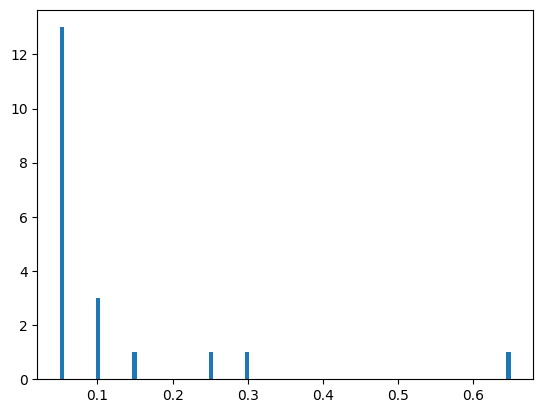

In [182]:
plt.hist(precision_top_features_by_model["exp8_gpt2_128"], bins=100, density=False)
plt.show()

### Analyzing top features

#### Feature plots for each models top feature

In [ ]:
import matplotlib.pyplot as plt

# Collect top feature for each model
top_feature_per_model = {k: v[0] for k, v in top_features_by_model.items()}

In [ ]:
sel_configs.keys()

dict_keys(['exp10_gpt2_8', 'exp5_gpt2_16', 'exp7_gpt2_32', 'exp8_gpt2_128'])

(13841,)
(13841,)


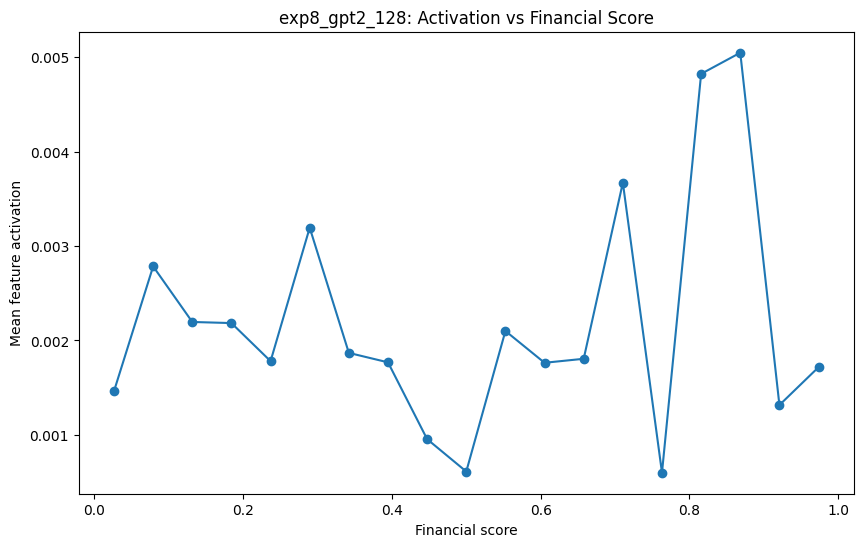

In [ ]:
plt.figure(figsize=(10, 6))

# for model_key, feat_idx in top_feature_per_model.items():

model_key = 'exp8_gpt2_128'
feat_idx = top_feature_per_model[model_key]
acts = all_model_activations[model_key].cpu().detach().numpy()
fin = financial_scores.detach().numpy()

# Get activations for the top feature
acts = acts[:, feat_idx]

print(fin.shape)
print(acts.shape)

bins = np.linspace(fin.min(), fin.max(), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mean_acts = []

for i in range(len(bins) - 1):
    mask = (fin >= bins[i]) & (fin < bins[i+1])
    mean_acts.append(acts[mask].mean() if mask.any() else np.nan)

plt.plot(bin_centers, mean_acts, marker='o')
plt.xlabel("Financial score")
plt.ylabel("Mean feature activation")
plt.title(f"{model_key}: Activation vs Financial Score")
plt.show()

/tmp/ipython-input-3296130951.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


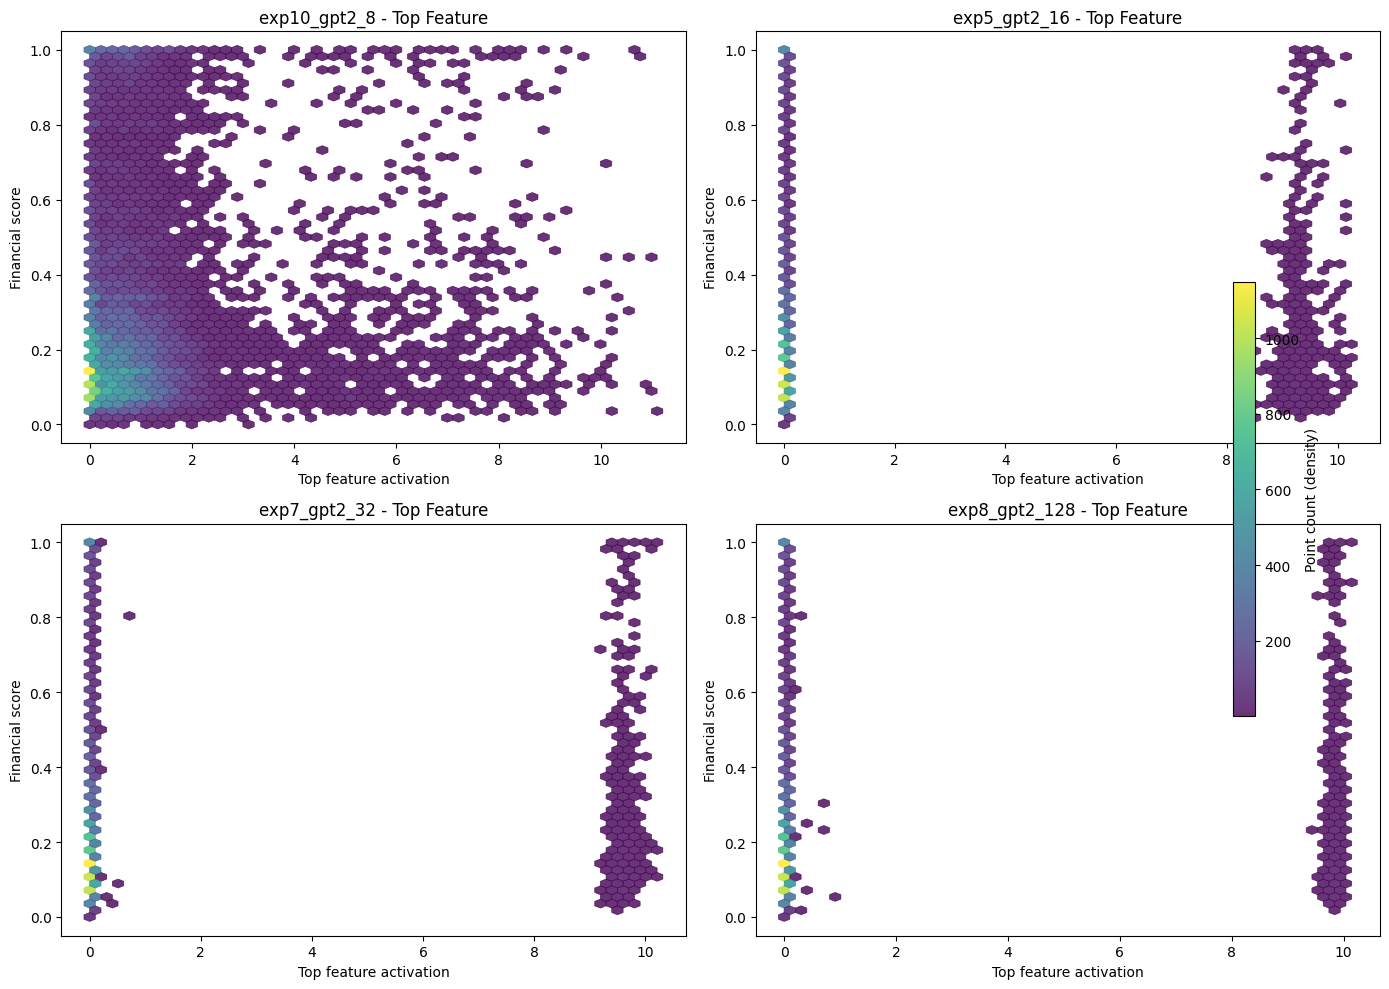

In [ ]:
import matplotlib.pyplot as plt

# Top feature for each model
top_feature_per_model = {k: v[0] for k, v in top_features_by_model.items()}

# Create subplots: 2x2 for 4 models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_key, feat_idx) in enumerate(top_feature_per_model.items()):
    ax = axes[idx]

    acts = all_model_activations[model_key].cpu()
    fin_scores = financial_scores.cpu()

    top_acts = acts[:, feat_idx].detach().numpy()
    fin_scores = fin_scores.numpy()

    hb = ax.hexbin(
        top_acts,
        fin_scores,
        gridsize=50,
        cmap='viridis',
        mincnt=1,
        linewidths=0.5,
        alpha=0.8
    )

    ax.set_xlabel("Top feature activation")
    ax.set_ylabel("Financial score")
    ax.set_title(f"{model_key} - Top Feature")

# Add a single colorbar for all subplots
cbar = fig.colorbar(hb, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Point count (density)")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example for a single top feature
feat_idx = top_feature_per_model["exp10_gpt2_8"]
acts = all_model_activations["exp10_gpt2_8"][:, feat_idx].detach().cpu().numpy()
fin_scores = financial_scores.cpu().numpy()

# Bin activations
bins = np.linspace(acts.min(), acts.max(), 100)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Compute density per bin
density = np.histogram(acts, bins=bins)[0]

# Compute average financial score per bin
avg_fin_score = []
for i in range(len(bins)-1):
    mask = (acts >= bins[i]) & (acts < bins[i+1])
    if mask.sum() > 0:
        avg_fin_score.append(fin_scores[mask].mean())
    else:
        avg_fin_score.append(np.nan)
avg_fin_score = np.array(avg_fin_score)

# Plot
plt.figure(figsize=(10,5))
plt.fill_between(
    bin_centers,
    0,
    density,
    color='lightgrey',
    alpha=0.5
)

plt.scatter(
    bin_centers,
    density,
    c=avg_fin_score,
    cmap='viridis',
    edgecolor='k',
    s=50
)

cbar = plt.colorbar()
cbar.set_label("Average Financial Score")

plt.xlabel("Feature Activation Level")
plt.ylabel("Density")
plt.title("Top Feature Activation vs Financial Score")
plt.show()


#### Feature specificity

Average number of unique tokens a feature fires to

#### Feature plots top tokens

In [ ]:
# Step A — Get top-k tokens
def get_top_k_tokens(feature_id, acts, tokens, k=20):
    feature_acts = acts[:, feature_id]  # (num_tokens,)

    values, indices = torch.sort(feature_acts, descending=True)

    # filter out non-firing
    mask = values > 0
    values = values[mask][:k]
    indices = indices[mask][:k]

    top_tokens = [tokens[i] for i in indices.tolist()]
    return top_tokens, values.cpu()

In [ ]:
# Take unique tokens and sum out activations
from collections import defaultdict


def get_top_token_types(feature_id, acts, tokens, k=20):
    feature_acts = acts[:, feature_id]  # shape: (num_tokens,)

    token_sums = defaultdict(float)

    # accumulate activation for each token *type*
    for tok, act in zip(tokens, feature_acts):
        act_val = act.item()
        if act_val > 0:
            token_sums[tok] += act_val

    # sort by total activation descending
    sorted_tokens = sorted(token_sums.items(), key=lambda x: x[1], reverse=True)

    # return top-k tokens and their summed activation
    top_tokens, top_values = zip(*sorted_tokens[:k])
    return list(top_tokens), torch.tensor(top_values).detach().cpu()

In [223]:
def plot_top_k_tokens(feature_id, acts, model_key,  tokens, k=20):
    top_tokens, values = get_top_token_types(feature_id, acts, tokens, k)

    plt.figure(figsize=(6, 6))
    plt.barh(range(len(values)), values.detach().cpu().numpy())
    plt.yticks(range(len(values)), top_tokens)
    plt.xlabel("Activation")
    plt.title(f"Dict x{model_key.split('_')[-1]}/{feature_id}")
    plt.gca().invert_yaxis()
    plt.show()

##### Visualize tokens of Top features for each model

In [279]:
model_key = 'exp7_gpt2_32'

In [280]:
feature_idx_list = top_features_by_model[model_key]
feature_idx_list[:20]

array([ 9380, 22781, 20141, 20892,  3052, 20909,     3, 16878, 24155,
       20103, 14443,  3303,  3889,  3457,  4453, 23427, 17871, 23434,
       13787, 23753])

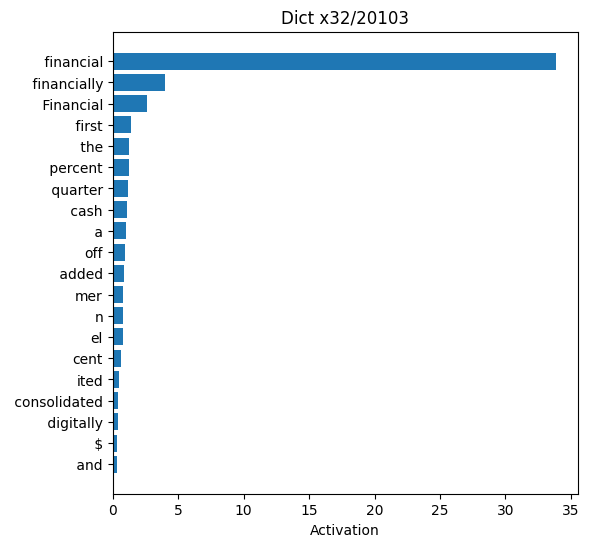

In [290]:
plot_top_k_tokens(20103, all_model_activations[model_key], model_key,  all_tokens, k=20)

#### Top features activations for each token

In [233]:
from collections import defaultdict

def build_token_index_map(tokens):

    tokens = [token.lower().strip() for token in tokens]
    token_to_indices = defaultdict(list)
    for i, tok in enumerate(tokens):
        token_to_indices[tok].append(i)
    return token_to_indices

token_to_indices = build_token_index_map(all_tokens)

In [234]:
def get_feature_activations_for_token(tokens_to_check, hidden_acts_torch, token_to_indices, top_k=20):

    idxs = []
    for token in tokens_to_check:
      if token not in token_to_indices:
          print((f"Token '{token}' not found in dataset"))
      else:
          idxs.extend(token_to_indices[token])           # list of positions

    if idxs == []:
        print("No token found")
        return [], []

    idxs = torch.tensor(idxs)
    acts = hidden_acts_torch[idxs]          # shape: (occurrences, hidden_dim)

    # Average activation across occurrences
    mean_acts = acts.mean(dim=0)             # shape: (hidden_dim,)
    normalized_acts = mean_acts / mean_acts.sum()

    # Get top-k features
    values, feat_ids = torch.topk(normalized_acts, k=top_k)

    # Detach for safety
    return feat_ids.cpu().numpy(), values.detach().cpu().numpy()


In [235]:
import matplotlib.pyplot as plt

def plot_token_feature_activations(tokens_to_check, feature_ids, activations):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_ids)), activations)
    plt.xticks(range(len(feature_ids)), feature_ids, rotation=45)
    plt.title(f"Top Activated SAE Features for Tokens: {tokens_to_check}")
    plt.xlabel("Feature ID")
    plt.ylabel("Activation")
    plt.tight_layout()
    plt.show()

##### Feature for different tokens in different models

In [291]:
tokens_to_check = ["financial"]

feature_ids, activations = get_feature_activations_for_token(
    tokens_to_check,
    all_model_activations[model_key],
    token_to_indices,
    top_k=20
)

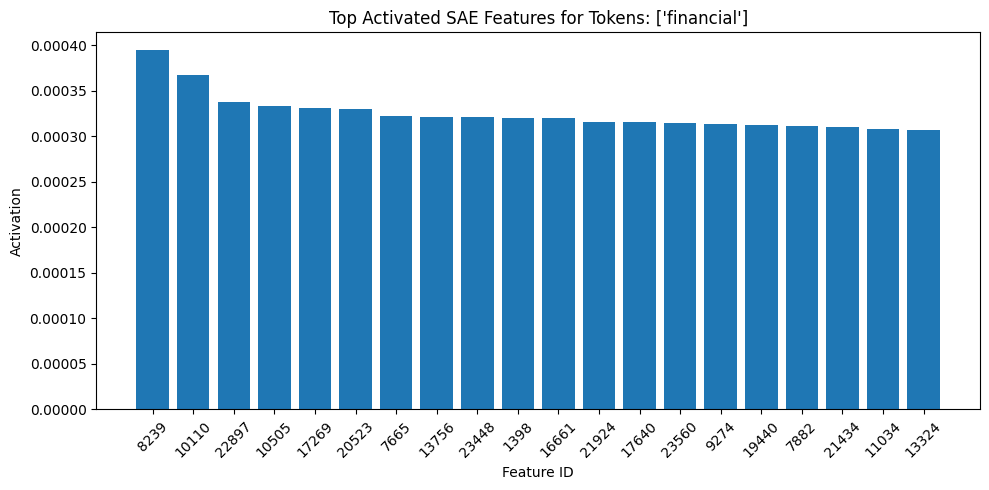

In [292]:
plot_token_feature_activations(tokens_to_check, feature_ids, activations)